<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imporitng-Required-Packages" data-toc-modified-id="Imporitng-Required-Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imporitng Required Packages</a></span></li><li><span><a href="#Importing-Dataset" data-toc-modified-id="Importing-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing Dataset</a></span></li><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train Test Split</a></span></li><li><span><a href="#ARMA-Model" data-toc-modified-id="ARMA-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>ARMA Model</a></span><ul class="toc-item"><li><span><a href="#Estimating-Lags" data-toc-modified-id="Estimating-Lags-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Estimating Lags</a></span></li></ul></li><li><span><a href="#Modeling-ARMA(1,-1)-Residuals" data-toc-modified-id="Modeling-ARMA(1,-1)-Residuals-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modeling ARMA(1, 1) Residuals</a></span><ul class="toc-item"><li><span><a href="#GARCH-Model" data-toc-modified-id="GARCH-Model-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>GARCH Model</a></span><ul class="toc-item"><li><span><a href="#Estimating-Lags" data-toc-modified-id="Estimating-Lags-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Estimating Lags</a></span></li><li><span><a href="#GARCH(2,-2)-Model" data-toc-modified-id="GARCH(2,-2)-Model-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>GARCH(2, 2) Model</a></span></li></ul></li></ul></li><li><span><a href="#ARMA(1,-1)-(Predictions)---GARCH(2,-2)-(Confidence-Levels)-Model" data-toc-modified-id="ARMA(1,-1)-(Predictions)---GARCH(2,-2)-(Confidence-Levels)-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>ARMA(1, 1) (Predictions) - GARCH(2, 2) (Confidence Levels) Model</a></span></li></ul></div>

# Imporitng Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.tsa.arima.model



from arch import arch_model

from sklearn.metrics import mean_squared_error

import warnings

sns.set()
warnings.filterwarnings("ignore")

# Importing Dataset

In [214]:
df = pd.read_csv('/windows/proga/АЛРОСА_ао_1day_01012005_01012023.txt',sep=';')\
    .rename(columns={'<DATE>':'DATE','<OPEN>':'OPEN','<LOW>':'LOW','<CLOSE>':'CLOSE','<VOL>':'VOL','<HIGH>':'HIGH','<TICKER>':'TICKER'})\
    .drop(['<PER>','<TIME>','<OPENINT>'],1)
df.DATE = pd.to_datetime(df.DATE,format="%Y%m%d")

In [215]:
df['spx_ret'] = df['CLOSE'].pct_change()
data = df[['DATE','spx_ret']].set_index('DATE')

In [216]:
data

,spx_ret
DATE,
2011-11-29,NaN
2011-11-30,0.400000
2011-12-01,0.400000
2011-12-02,-0.400000
2011-12-05,-0.191087
...,...
2022-12-26,0.001858
2022-12-27,-0.003372
2022-12-28,-0.015057


# Train Test Split

In [217]:
train_df = data.loc[:"2022-07-01"]
test_df = data.loc["2022-07-02":]
print('Доля тестовой выборки : {}%'.format( round( len(test_df)/len(data)*100 , 2 ) ) )

Доля тестовой выборки : 4.64%


# ARMA Model

## Estimating Lags

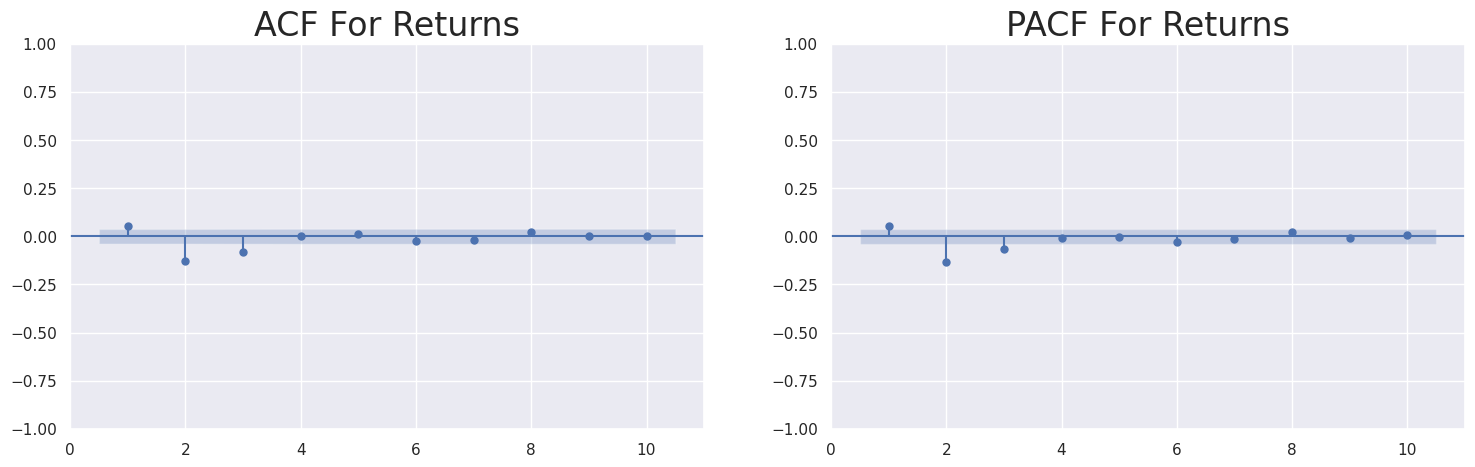

In [218]:
plt.rcParams["figure.figsize"] = 18, 5

fig, axes = plt.subplots(1, 2)

sgt.plot_acf(train_df.spx_ret[1:], zero = False, lags = 10, ax = axes[0])
sgt.plot_pacf(train_df.spx_ret[1:], zero = False, lags = 10, ax = axes[1])

axes[0].set_title("ACF For Returns", size = 24)
axes[1].set_title("PACF For Returns", size = 24)

plt.show()

In [219]:
res = statsmodels.tsa.stattools.arma_order_select_ic(train_df.spx_ret, ic=["aic", "bic"])
print('AIC{}'.format(res.aic_min_order))
print('BIC{}'.format(res.bic_min_order))

AIC(3, 0)
BIC(3, 0)


**Building the Model**

In [220]:
model = ARIMA(train_df["spx_ret"][1:], order =(3,0,0))
model_results = model.fit()
print(model_results.summary())

                               SARIMAX Results                                
Dep. Variable:                spx_ret   No. Observations:                 2648
Model:                 ARIMA(3, 0, 0)   Log Likelihood                6078.306
Date:                Tue, 22 Aug 2023   AIC                         -12146.612
Time:                        14:59:20   BIC                         -12117.204
Sample:                             0   HQIC                        -12135.966
                               - 2648                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.047      0.295      -0.000       0.001
ar.L1          0.0516      0.005     11.114      0.000       0.042       0.061
ar.L2         -0.1499      0.006    -24.596      0.0

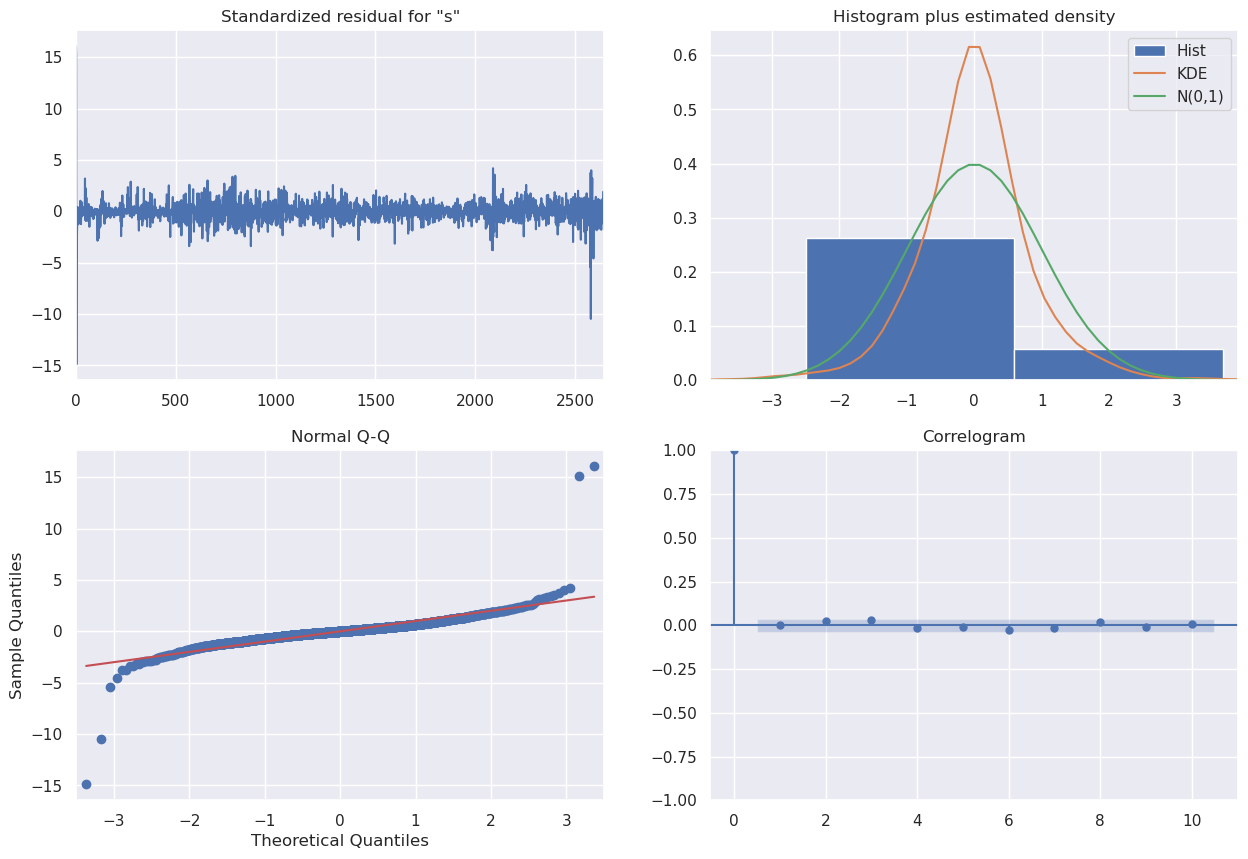

In [221]:
model_results.plot_diagnostics(figsize=(15, 10))
plt.show()

**Predictions**

In [222]:
arma_forecast = model_results.get_forecast(len(test_df.index))
arma_predictions_df = arma_forecast.conf_int(alpha = 0.05) # Confidence level of 95%
arma_predictions_df["Predictions"] = model_results.predict(start=train_df.shape[0],end=(train_df.shape[0]+test_df.shape[0]-1), dynamic=False)
arma_predictions_df  = arma_predictions_df.dropna()

**Plot of Predicted vs Actual Values**

In [223]:
test_df = test_df.loc['2022-07-05':]

In [224]:
arma_predictions_df = arma_predictions_df.set_index(test_df.index)

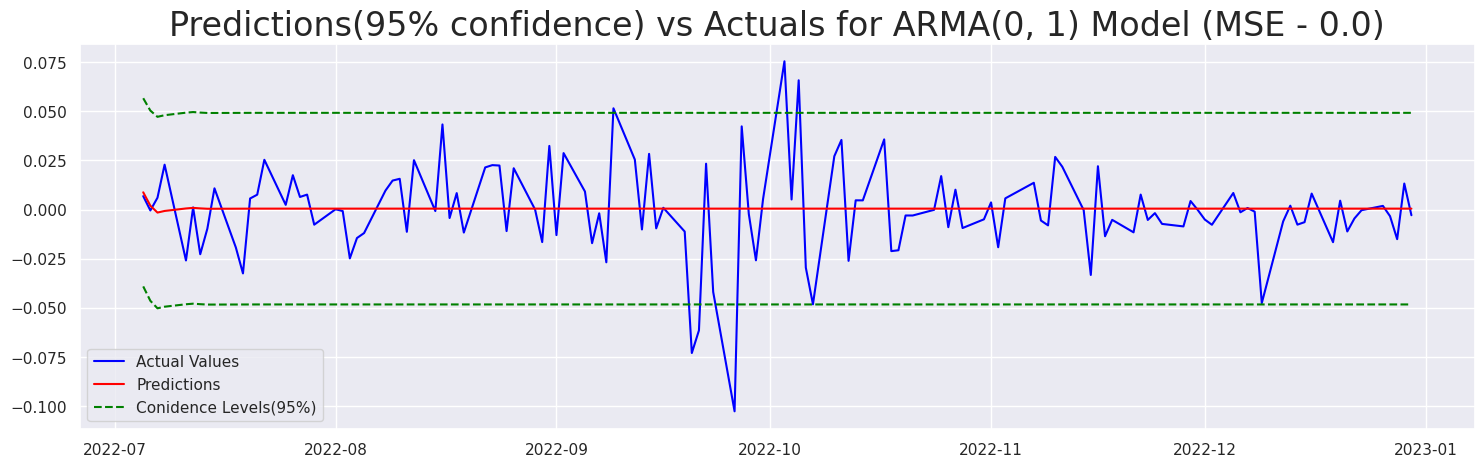

In [225]:
arma_mse = mean_squared_error(test_df["spx_ret"].values, arma_predictions_df["Predictions"])

plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["spx_ret"], color = "blue", label = "Actual Values")

plt.plot(arma_predictions_df["Predictions"], color = "red", label = "Predictions")
plt.plot(arma_predictions_df["upper spx_ret"], color = "green", linestyle = "--", label = "Conidence Levels(95%)")
plt.plot(arma_predictions_df["lower spx_ret"], color = "green", linestyle = "--")

plt.title(f"Predictions(95% confidence) vs Actuals for ARMA(0, 1) Model (MSE - {round(arma_mse, 2)})", size = 24)

plt.legend()
plt.show()

# Modeling ARMA(0, 1) Residuals

Plotting **Residuals** of **ARMA(0, 1)** Model

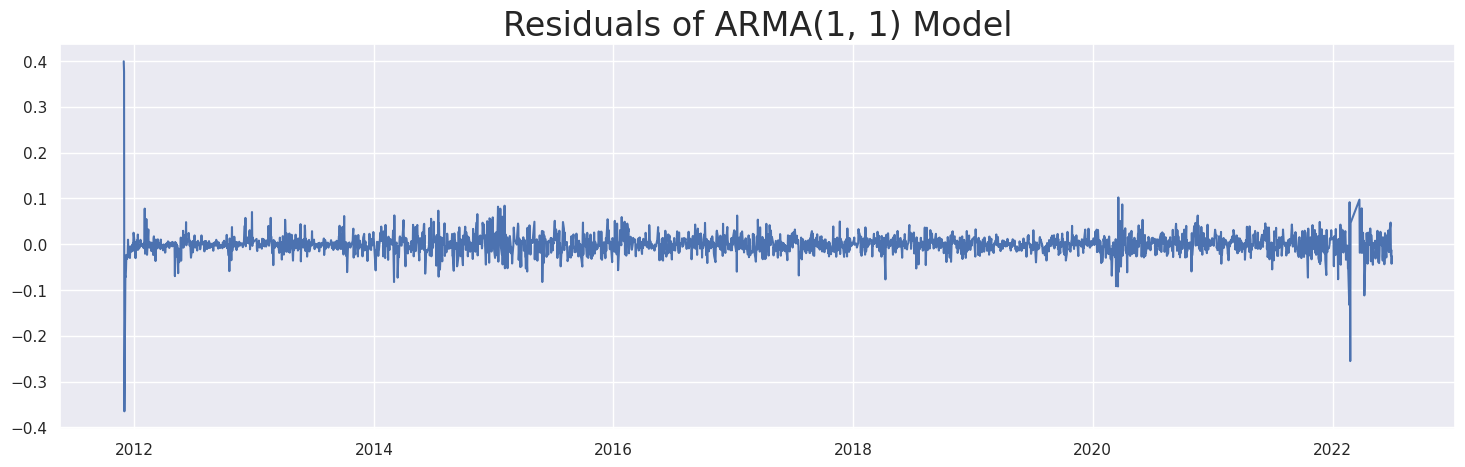

In [226]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(model_results.resid)
plt.title("Residuals of ARMA(1, 1) Model", size = 24)

plt.show()

Through this plot, it is obvious that the variance varies with time and hence modeling this with a **GARCH** model may be reasonable. 

## GARCH Model

### Estimating Lags

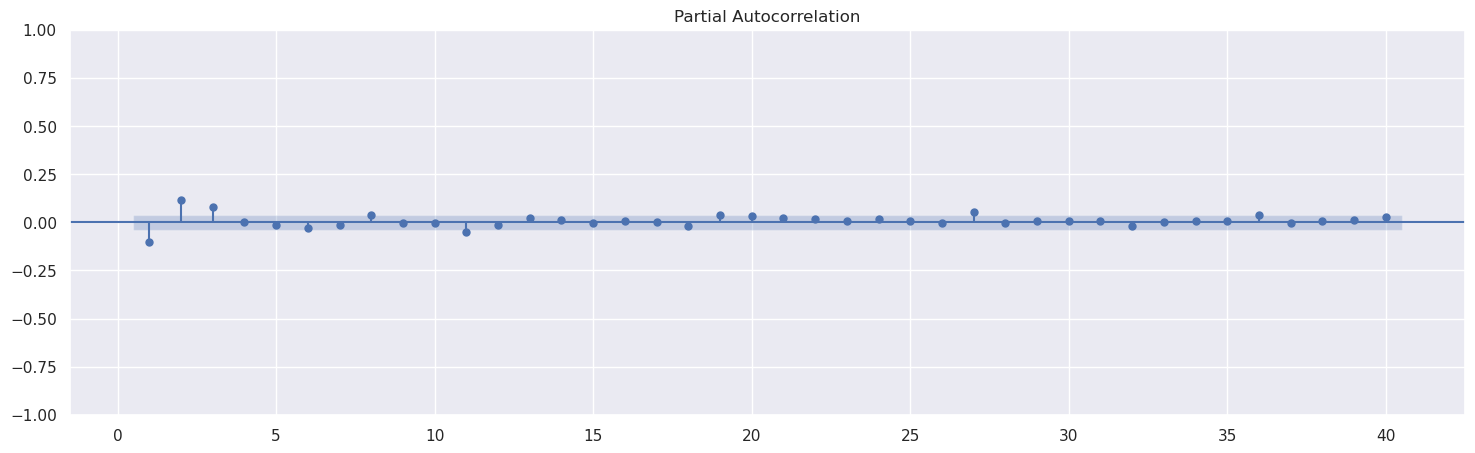

In [227]:
plt.rcParams["figure.figsize"] = 18, 5

sgt.plot_pacf(model_results.resid[1:], zero = False, lags = 40)

plt.show()

### GARCH(2, 2) Model

**Preparing Data**

In [228]:
resid_df = data.copy()
resid_df["spx_ret_resid"] = resid_df["spx_ret"].shift(1).loc[resid_df.index]
resid_df.loc[train_df.index[1]:train_df.index[-1], "spx_ret_resid"] = model_results.resid

**Building the Model**

**Note**: In some cases, the model may fail to converge. In such case, running the code cell below will most likely fix the issue. However, one can also follow the approach given [here](https://quant.stackexchange.com/questions/32350/fitting-garch1-1-in-python-for-moderately-large-data-sets) for a more robust solution.

In [236]:
resid_model = arch_model(resid_df["spx_ret_resid"][1:], p = 1, q = 2 , vol = "GARCH")
resid_model_results = resid_model.fit(last_obs = test_df.index[0], update_freq = 5)
resid_model_results.summary()

Iteration:      5,   Func. Count:     60,   Neg. LLF: 5355263.306318347
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6703.854940021018
            Iterations: 10
            Function evaluations: 73
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:          spx_ret_resid   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6703.85
Distribution:                  Normal   AIC:                          -13397.7
Method:            Maximum Likelihood   BIC:                          -13368.3
                                        No. Observations:                 2649
Date:                Tue, Aug 22 2023   Df Residuals:                     2648
Time:                        15:01:06   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.1734e-04  3.177e-04     -0.369      0.712 [-7.401e-04,5.054e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.9858e-05  1.856e-05      3.225  1.258e-03 [2.348e-05,9.623e-05]
alpha[1]       0.2000  5.270e-02      3.795  1.478e-04   [9.670e-02,  0.303]
beta[1]        0.3500      0.103      3.386  7.101e-04     [  0.147,  0.553]
beta[2]        0.3500      0.111      3.155  1.607e-03     [  0.133,  0.567]
============================================================================

Covariance estimator: robust
"""

**Predictions**

In [237]:
resid_forecasts = resid_model_results.forecast().residual_variance.loc[test_df.index].values

# ARMA(1, 1) (Predictions) - GARCH(2, 2) (Confidence Levels) Model

In [238]:
arma_garch_predictions_df = arma_predictions_df.copy()
arma_garch_predictions_df["lower spx_ret"] = arma_garch_predictions_df["Predictions"] - resid_forecasts.reshape(-1,)
arma_garch_predictions_df["upper spx_ret"] = arma_garch_predictions_df["Predictions"] + resid_forecasts.reshape(-1,)

In [155]:
arma_garch_predictions_df.head()

,lower spx_ret,upper spx_ret,Predictions
DATE,,,
2022-07-05,-0.004401,0.004915,0.000257
2022-07-06,-0.004258,0.004771,0.000257
2022-07-07,-0.003954,0.004467,0.000257
2022-07-08,-0.003675,0.004188,0.000257
2022-07-11,-0.003407,0.003921,0.000257


**Plotting the Final Predictions + Confidence Intervals**

[]

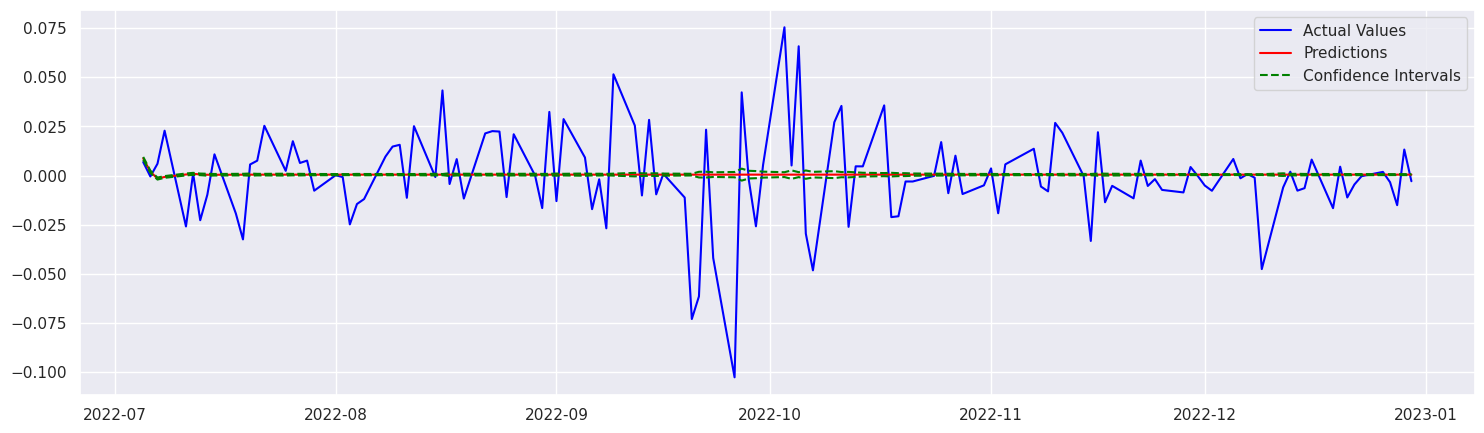

In [239]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["spx_ret"], color = "blue", label = "Actual Values")

plt.plot(arma_garch_predictions_df["Predictions"][test_df.index], color = "red", label = "Predictions")
plt.plot(arma_garch_predictions_df["lower spx_ret"][test_df.index], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(arma_garch_predictions_df["upper spx_ret"][test_df.index], color = "green", linestyle = "--")

plt.legend()
plt.plot()